In [24]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras import Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import L1, L2, L1L2
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.layers import concatenate

In [25]:
###load dataframes and do a bit of preprocessing of ttrain
ttrain=pd.read_csv('./news_ttrain.csv')
tvalid=pd.read_csv('./news_tvalid.csv')
###Train a tokenizer and convert to integer sequences
tokenizer=Tokenizer()
train_list_str=ttrain['cleaned_words'].tolist()
tokenizer.fit_on_texts(train_list_str)
train_list = tokenizer.texts_to_sequences(train_list_str)
###compute number of distinct words, the max length of a sequence, and pad sequences to be equal length 
tlmax_len=max([len(tlist) for tlist in train_list])
tlnum_words=max([max(tlist) for tlist in train_list])
train_list = pad_sequences(train_list, maxlen=tlmax_len)

In [26]:
print(tlmax_len, tlnum_words)
train_list

154 55015


array([[    0,     0,     0, ...,  3418,    29,  9041],
       [    0,     0,     0, ...,  1775,  9042, 32003],
       [    0,     0,     0, ...,   150,   430,   226],
       ...,
       [    0,     0,     0, ...,   458,  1596,    34],
       [    0,     0,     0, ...,   627,   189,  4577],
       [    0,     0,     0, ...,    72,   481,     1]], dtype=int32)

In [27]:
###now we preprocess the validation set
valid_list_str=tvalid['cleaned_words'].tolist()
valid_list = tokenizer.texts_to_sequences(valid_list_str)
###need to truncate any strings that are too long, then pad to appropriate length
valid_list = [tlist[0:tlmax_len] for tlist in valid_list]
valid_list = pad_sequences(valid_list, maxlen=tlmax_len)

In [28]:
print(train_list.shape)
print(valid_list.shape)

(83720, 154)
(20931, 154)


In [29]:
###Now we make one hot encoded y vectors for the train and validation sets
ytrain= pd.get_dummies(ttrain['category_col']).to_numpy()
yvalid= pd.get_dummies(tvalid['category_col']).to_numpy()
print(ytrain.shape, yvalid.shape)
ytrain

(83720, 12) (20931, 12)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [34]:
###Some model hyperparameters, chosen by training different models over a set of options
embed_len=256
reg_param=0 ### in testing, even small regularization worsened accuracy
lr=0.0002 ###smaller than default learning rate leads to more stable outcomes, albeit longer train times
nfeatures=256

input = Input(shape=tlmax_len)
x = input
x=Embedding(tlnum_words+1, embed_len, input_length=tlmax_len, mask_zero=True)(x)

###Model creates 3 filters over kernels of size 2, 4, and 6. kernel arrangement chosen as the best from a list of tested options
tower_1 = Conv1D(nfeatures, 2, padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
tower_1 = GlobalMaxPooling1D() (tower_1)
tower_2 = Conv1D(nfeatures, 4, padding='valid', activation='relu',kernel_regularizer=L2(reg_param))(x)
tower_2 = GlobalMaxPooling1D() (tower_2)
tower_3 = Conv1D(nfeatures, 6, padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
tower_3 = GlobalMaxPooling1D() (tower_3)

###Merge the output of the 3 filters, flatten, then combine their output with a dense sigmoid layer with dropout
merged = concatenate([tower_1, tower_2, tower_3], axis=1)
merged = Flatten()(merged)
merged = Dropout(0.3)(merged)
output=Dense(12, activation='sigmoid', kernel_regularizer=L1(reg_param))(merged)
model=Model(inputs=input, outputs=output)
###Compile model with custom choice of learning rate and binary crossentropy loss
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])


In [35]:
out=model.fit(train_list, ytrain, validation_split=0.15, epochs=3, callbacks=[es])

Epoch 1/3
2224/2224 [==============================] - 1151s 517ms/step - loss: 0.1751 - accuracy: 0.5901 - val_loss: 0.1145 - val_accuracy: 0.7503
Epoch 2/3
2224/2224 [==============================] - 1179s 530ms/step - loss: 0.0938 - accuracy: 0.8040 - val_loss: 0.0935 - val_accuracy: 0.8005
Epoch 3/3
2224/2224 [==============================] - 1156s 520ms/step - loss: 0.0685 - accuracy: 0.8642 - val_loss: 0.0899 - val_accuracy: 0.8095


In [36]:
###Generate prediction vector on the validation set 
categories = ['BLACK VOICES', 'BUSINESS', 'ENTERTAINMENT', 'FOOD & DRINK', 'PARENTING', 'POLITICS', 'QUEER VOICES', 'SPORTS', 'STYLE & BEAUTY', 'TRAVEL', 'WELLNESS', 'WORLD NEWS'] 
y_pred=model.predict(valid_list).tolist()
ypred1=[]
ypred2=[]
for tlist in y_pred:
    tmax=max(tlist)
    temp=[1 if i==tmax else 0 for i in tlist]
    for i, j in enumerate(temp):
        if j==1:
            ypred2.append(categories[i])
    ypred1.append(temp)
accuracy_score(ypred1, yvalid)


0.8132435144044718

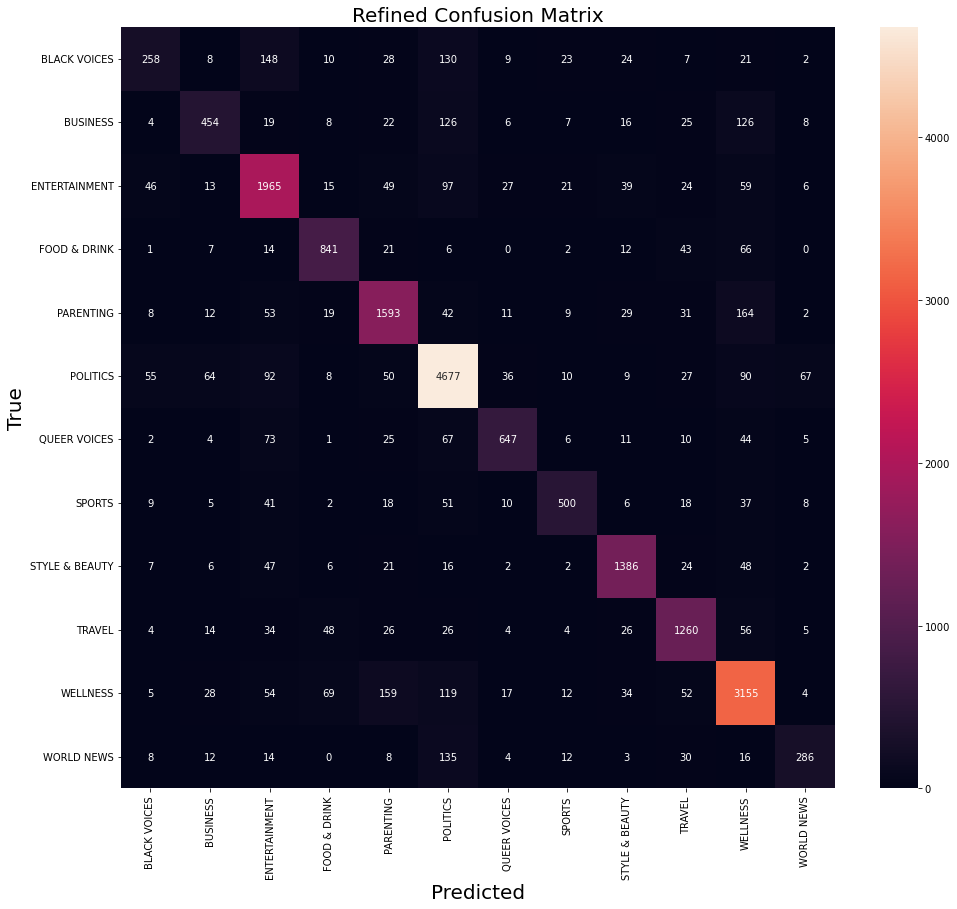

In [37]:
cm = confusion_matrix(tvalid['category_col'].to_list(), ypred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
labels = categories
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)
plt.show()

In [38]:
print(classification_report(yvalid, ypred1,target_names=categories))

                precision    recall  f1-score   support

  BLACK VOICES       0.63      0.39      0.48       668
      BUSINESS       0.72      0.55      0.63       821
 ENTERTAINMENT       0.77      0.83      0.80      2361
  FOOD & DRINK       0.82      0.83      0.82      1013
     PARENTING       0.79      0.81      0.80      1973
      POLITICS       0.85      0.90      0.88      5185
  QUEER VOICES       0.84      0.72      0.78       895
        SPORTS       0.82      0.71      0.76       705
STYLE & BEAUTY       0.87      0.88      0.88      1567
        TRAVEL       0.81      0.84      0.82      1507
      WELLNESS       0.81      0.85      0.83      3708
    WORLD NEWS       0.72      0.54      0.62       528

     micro avg       0.81      0.81      0.81     20931
     macro avg       0.79      0.74      0.76     20931
  weighted avg       0.81      0.81      0.81     20931
   samples avg       0.81      0.81      0.81     20931



In [39]:
tvalid['cnn_cat_pred']= ypred2

In [41]:
tvalid.to_pickle('./tvalid_with_pred.pkl')

The cells below were tests run to determine choices of architecture/hyperparameters for the model. They are included for informational purposes for further perusement but do not need to be run, and are not fully commented. 

In [161]:
tlist=[[3, 4, 5], [2, 4, 6], [3, 5, 7], [1, 4, 7], [1, 3, 5]]
reg_param=0.000001
categories = ['BLACK VOICES', 'BUSINESS', 'ENTERTAINMENT', 'FOOD & DRINK', 'PARENTING', 'POLITICS', 'QUEER VOICES', 'SPORTS', 'STYLE & BEAUTY', 'TRAVEL', 'WELLNESS', 'WORLD NEWS'] 
for temp in tlist:
    input = Input(shape=tlmax_len)
    x = input
    x=Embedding(tlnum_words+1, 64, input_length=tlmax_len, mask_zero=True)(x)

    tower_1 = Conv1D(300, temp[0], padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
    tower_1 = GlobalMaxPooling1D() (tower_1)
    tower_2 = Conv1D(300, temp[1], padding='valid', activation='relu',kernel_regularizer=L2(reg_param))(x)
    tower_2 = GlobalMaxPooling1D() (tower_2)
    tower_3 = Conv1D(300, temp[2], padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
    tower_3 = GlobalMaxPooling1D() (tower_3)

    merged = concatenate([tower_1, tower_2, tower_3], axis=1)
    merged = Flatten()(merged)
    merged = Dropout(0.3)(merged)
    output=Dense(12, activation='sigmoid', kernel_regularizer=L1(reg_param))(merged)
    model=Model(inputs=input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
    yeet = model.fit(train_list, ytrain, validation_split=0.15, epochs=20, callbacks=[es])
    y_pred=model.predict(valid_list).tolist()
    ypred1=[]
    ypred2=[]
    for tlist in y_pred:
        tmax=max(tlist)
        temp=[1 if i==tmax else 0 for i in tlist]
        for i, j in enumerate(temp):
            if j==1:
                ypred2.append(categories[i])
        ypred1.append(temp)
    print("Validation accuracy:")
    print(accuracy_score(ypred1, yvalid))

Epoch 1/20
2224/2224 [==============================] - 412s 185ms/step - loss: 0.1320 - accuracy: 0.7119 - val_loss: 0.0966 - val_accuracy: 0.8008
Epoch 2/20
2224/2224 [==============================] - 411s 185ms/step - loss: 0.0744 - accuracy: 0.8567 - val_loss: 0.0960 - val_accuracy: 0.8082
Epoch 3/20
2224/2224 [==============================] - 414s 186ms/step - loss: 0.0483 - accuracy: 0.9204 - val_loss: 0.1077 - val_accuracy: 0.8020
Epoch 00003: early stopping
Validation accuracy:
0.800917299699011
Epoch 1/20
2224/2224 [==============================] - 426s 191ms/step - loss: 0.1314 - accuracy: 0.7102 - val_loss: 0.0951 - val_accuracy: 0.8026
Epoch 2/20
2224/2224 [==============================] - 425s 191ms/step - loss: 0.0730 - accuracy: 0.8590 - val_loss: 0.0938 - val_accuracy: 0.8115
Epoch 3/20
2224/2224 [==============================] - 423s 190ms/step - loss: 0.0472 - accuracy: 0.9213 - val_loss: 0.1073 - val_accuracy: 0.8036
Epoch 00003: early stopping
Validation accura

In [160]:
tlist=[1, 2, 3, 4, 5, 6, 7]
categories = ['BLACK VOICES', 'BUSINESS', 'ENTERTAINMENT', 'FOOD & DRINK', 'PARENTING', 'POLITICS', 'QUEER VOICES', 'SPORTS', 'STYLE & BEAUTY', 'TRAVEL', 'WELLNESS', 'WORLD NEWS'] 
for width in tlist:
    model = Sequential() 
    model.add(Embedding(tlnum_words+1, 64, input_length=tlmax_len, mask_zero=True)) 
    model.add(Conv1D(500, width, padding='same', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.3))
    model.add(Dense(12, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
    yeet = model.fit(train_list, ytrain, validation_split=0.15, epochs=20, callbacks=[es])
    y_pred=model.predict(valid_list).tolist()
    ypred1=[]
    ypred2=[]
    for tlist in y_pred:
        tmax=max(tlist)
        temp=[1 if i==tmax else 0 for i in tlist]
        for i, j in enumerate(temp):
            if j==1:
                ypred2.append(categories[i])
        ypred1.append(temp)
    print("Validation accuracy:")
    print(accuracy_score(ypred1, yvalid))

Epoch 1/20
2224/2224 [==============================] - 215s 96ms/step - loss: 0.1566 - accuracy: 0.6473 - val_loss: 0.1112 - val_accuracy: 0.7577
Epoch 2/20
2224/2224 [==============================] - 205s 92ms/step - loss: 0.1037 - accuracy: 0.7821 - val_loss: 0.1002 - val_accuracy: 0.7846
Epoch 3/20
2224/2224 [==============================] - 208s 94ms/step - loss: 0.0867 - accuracy: 0.8228 - val_loss: 0.0990 - val_accuracy: 0.7884
Epoch 4/20
2224/2224 [==============================] - 200s 90ms/step - loss: 0.0735 - accuracy: 0.8586 - val_loss: 0.1027 - val_accuracy: 0.7846
Epoch 00004: early stopping
Validation accuracy:
0.789737709617314
Epoch 1/20
2224/2224 [==============================] - 211s 95ms/step - loss: 0.1509 - accuracy: 0.6615 - val_loss: 0.1051 - val_accuracy: 0.7743
Epoch 2/20
2224/2224 [==============================] - 220s 99ms/step - loss: 0.0927 - accuracy: 0.8098 - val_loss: 0.0965 - val_accuracy: 0.7960
Epoch 3/20
2224/2224 [=============================

In [163]:
input = Input(shape=tlmax_len)
x = input
x=Embedding(tlnum_words+1, 64, input_length=tlmax_len, mask_zero=True)(x)

tower_1 = Conv1D(130, 1, padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
tower_1 = GlobalMaxPooling1D() (tower_1)
tower_2 = Conv1D(130, 2, padding='valid', activation='relu',kernel_regularizer=L2(reg_param))(x)
tower_2 = GlobalMaxPooling1D() (tower_2)
tower_3 = Conv1D(130, 3, padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
tower_3 = GlobalMaxPooling1D() (tower_3)
tower_4 = Conv1D(130, 4, padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
tower_4 = GlobalMaxPooling1D() (tower_4)
tower_5 = Conv1D(130, 5, padding='valid', activation='relu',kernel_regularizer=L2(reg_param))(x)
tower_5 = GlobalMaxPooling1D() (tower_5)
tower_6 = Conv1D(130, 6, padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
tower_6 = GlobalMaxPooling1D() (tower_6)
tower_7 = Conv1D(130, 7, padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
tower_7 = GlobalMaxPooling1D() (tower_7)

merged = concatenate([tower_1, tower_2, tower_3, tower_4, tower_5, tower_6, tower_7], axis=1)
merged = Flatten()(merged)
merged = Dropout(0.3)(merged)
output=Dense(12, activation='sigmoid', kernel_regularizer=L1(reg_param))(merged)
model=Model(inputs=input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
yeet = model.fit(train_list, ytrain, validation_split=0.15, epochs=20, callbacks=[es])

Epoch 1/20
2224/2224 [==============================] - 489s 219ms/step - loss: 0.1314 - accuracy: 0.7114 - val_loss: 0.0950 - val_accuracy: 0.7999
Epoch 2/20
2224/2224 [==============================] - 500s 225ms/step - loss: 0.0731 - accuracy: 0.8596 - val_loss: 0.0954 - val_accuracy: 0.8076
Epoch 00002: early stopping


In [23]:
tlist=[64, 128, 256]
reg_param=0.0000002
lr=0.0002
nfeatures=256
categories = ['BLACK VOICES', 'BUSINESS', 'ENTERTAINMENT', 'FOOD & DRINK', 'PARENTING', 'POLITICS', 'QUEER VOICES', 'SPORTS', 'STYLE & BEAUTY', 'TRAVEL', 'WELLNESS', 'WORLD NEWS'] 
for embed_len in tlist:
    input = Input(shape=tlmax_len)
    x = input
    x=Embedding(tlnum_words+1, embed_len, input_length=tlmax_len, mask_zero=True)(x)

    tower_1 = Conv1D(nfeatures, 2, padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
    tower_1 = GlobalMaxPooling1D() (tower_1)
    tower_2 = Conv1D(nfeatures, 4, padding='valid', activation='relu',kernel_regularizer=L2(reg_param))(x)
    tower_2 = GlobalMaxPooling1D() (tower_2)
    tower_3 = Conv1D(nfeatures, 6, padding='valid', activation='relu', kernel_regularizer=L2(reg_param))(x)
    tower_3 = GlobalMaxPooling1D() (tower_3)

    merged = concatenate([tower_1, tower_2, tower_3], axis=1)
    merged = Flatten()(merged)
    merged = Dropout(0.3)(merged)
    output=Dense(12, activation='sigmoid', kernel_regularizer=L1(reg_param))(merged)
    model=Model(inputs=input, outputs=output)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
    yeet = model.fit(train_list, ytrain, validation_split=0.15, epochs=20, callbacks=[es])
    y_pred=model.predict(valid_list).tolist()
    ypred1=[]
    ypred2=[]
    for tlist in y_pred:
        tmax=max(tlist)
        temp=[1 if i==tmax else 0 for i in tlist]
        for i, j in enumerate(temp):
            if j==1:
                ypred2.append(categories[i])
        ypred1.append(temp)
    print("Validation accuracy:")
    print(accuracy_score(ypred1, yvalid))

Epoch 1/20
2224/2224 [==============================] - 329s 147ms/step - loss: 0.2047 - accuracy: 0.5099 - val_loss: 0.1382 - val_accuracy: 0.6901
Epoch 2/20
2224/2224 [==============================] - 322s 145ms/step - loss: 0.1185 - accuracy: 0.7406 - val_loss: 0.1115 - val_accuracy: 0.7550
Epoch 3/20
2224/2224 [==============================] - 323s 145ms/step - loss: 0.0922 - accuracy: 0.8089 - val_loss: 0.0987 - val_accuracy: 0.7875
Epoch 4/20
2224/2224 [==============================] - 320s 144ms/step - loss: 0.0742 - accuracy: 0.8518 - val_loss: 0.0936 - val_accuracy: 0.8036
Epoch 5/20
2224/2224 [==============================] - 323s 145ms/step - loss: 0.0614 - accuracy: 0.8830 - val_loss: 0.0942 - val_accuracy: 0.8075
Epoch 00005: early stopping
Validation accuracy:
0.8095169843772395
Epoch 1/20
2224/2224 [==============================] - 599s 269ms/step - loss: 0.1890 - accuracy: 0.5523 - val_loss: 0.1248 - val_accuracy: 0.7169
Epoch 2/20
2224/2224 [======================